<a href="https://colab.research.google.com/github/omdena/earthquake/blob/master/Demo_OpenStreetMap_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, IPython
os.system("apt-get install -qq curl g++ make; curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz")
os.chdir('spatialindex-src-1.8.5')
os.system("./configure; make; make install; pip install rtree ;ldconfig")
os.chdir('/content')
os.system('apt-get update; apt-get install -y libproj-dev proj-data proj-bin libgeos-dev libspatialindex-dev')
os.system('pip install pysal cython cartopy geoplot geopandas osmnx coverage coveralls folium pytest scikit-learn scipy sphinx twine  descartes Shapely')
import networkx as nx
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd

## Get map around a point

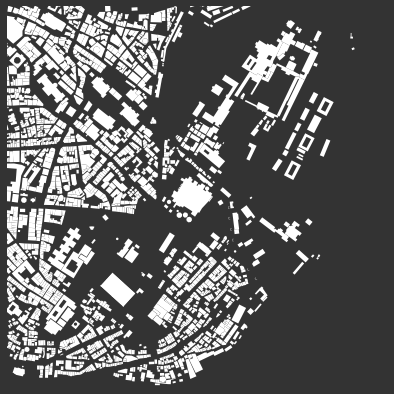

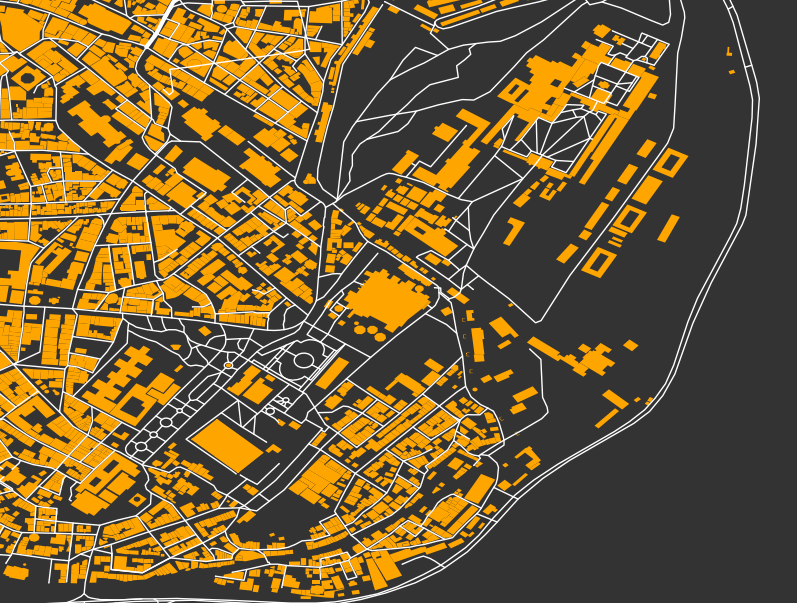

In [2]:
#@title Centered on Hagia Sophia (41.008469, 28.980261)
point = (41.008469, 28.980261) # Hagia Sophia
Area_in_KmSqur = 2 #@param {type:"slider", min:1, max:15, step:1}
dist = int(np.sqrt(Area_in_KmSqur*1000000)/2) # distance from center to edges of box

gdf = ox.footprints.footprints_from_point(point=point, distance=dist)
gdf_proj = ox.project_gdf(gdf)
bbox = ox.bbox_from_point(point=point, distance=dist, project_utm=True)
fig, ax = ox.footprints.plot_footprints(gdf_proj, bgcolor='#333333', color='w', figsize=(7,7), bbox=bbox, show=True)
plt.show()

def make_plot(place, point, dist, gdf, network_type='drive', bldg_color='orange', dpi=100, default_width=4, street_widths=None):
  fig, ax = ox.plot_figure_ground(point=point, dist=dist, network_type=network_type, default_width=default_width, street_widths=street_widths, save=False, show=False, close=True)
  fig, ax = ox.footprints.plot_footprints(gdf, fig=fig, ax=ax, color=bldg_color, set_bounds=False, save=True, show=False, close=True, filename=place, dpi=dpi)
  return f'images/{place}.png'

path = make_plot(place = 'Hagia_Sophia',point = (41.008469, 28.980261),dist = dist, gdf=gdf, network_type='all', default_width=1, street_widths={'secondary':3})
Image(path, height=600, width=600)

## Represent map as a Network

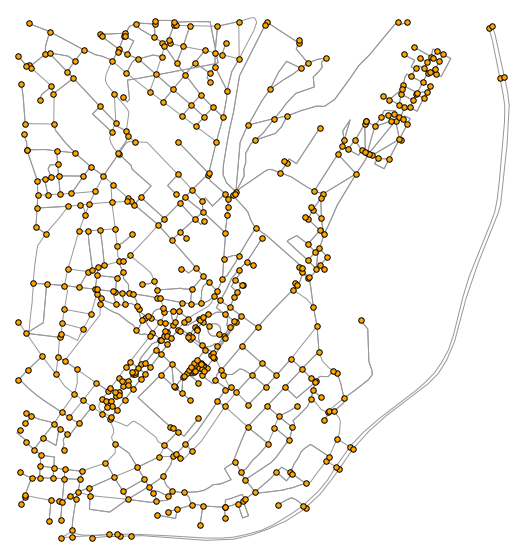

NumNodes:589,
NumEdges:1532


In [3]:
# retrieve map data as a graph of nodes and edges
G = ox.core.graph_from_point(center_point=point, distance = dist)
fig, ax = ox.plot_graph(G, fig_height=10, node_color='orange', node_size=30, node_zorder=2, node_edgecolor='k')
plt.show()
print(f'NumNodes:{G.number_of_nodes()},\nNumEdges:{G.number_of_edges()}')

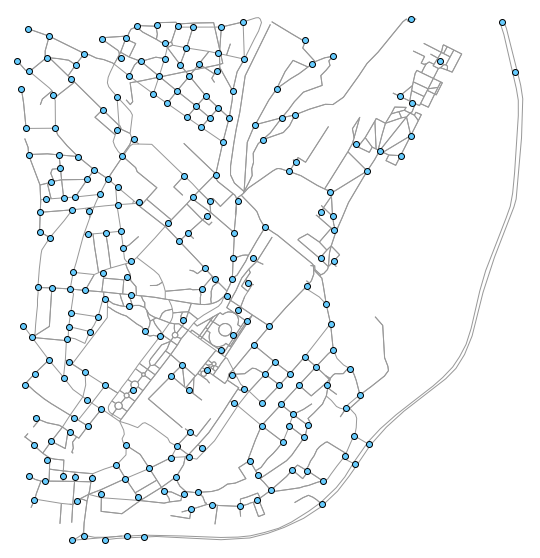

NumNodes:589,
NumEdges:1532


In [4]:
# clean up the intersections and extract their xy coords
G = ox.project_graph(G)
intersections = ox.clean_intersections(G, tolerance=15, dead_ends=False)
points = np.array([point.xy for point in intersections])

# plot the cleaned-up intersections
fig, ax = ox.plot_graph(G, fig_height=10, show=False, close=False, node_alpha=0)
ax.scatter(x=points[:,0], y=points[:,1], zorder=2, color='#66ccff', edgecolors='k')
plt.show()
print(f'NumNodes:{G.number_of_nodes()},\nNumEdges:{G.number_of_edges()}')

## Street Types on map

In [0]:
StreetTypes = edges_df.highway.copy()
StreetTypes = StreetTypes.apply(lambda x: '_'.join(x) if isinstance(x,list) else x)
bin_labels = range(len(StreetTypes.unique()))
cats = StreetTypes.unique()
colors = ox.get_colors(len(StreetTypes.unique()), 'jet', 0, 1, alpha = 0.7)
edge_colors = [colors[i] if pd.notnull(cat) else na_color for i, cat in enumerate(cats)]

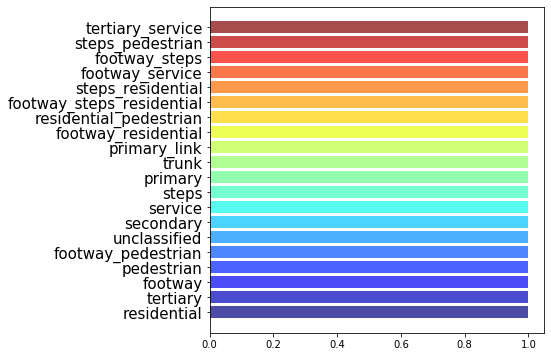

In [118]:
plt.figure(figsize=(6,6))
plt.barh(np.arange(len(cats)), np.ones(len(cats)), color=edge_colors)
plt.yticks(np.arange(len(cats)), cats)
plt.rc('ytick', labelsize=12)
plt.show()

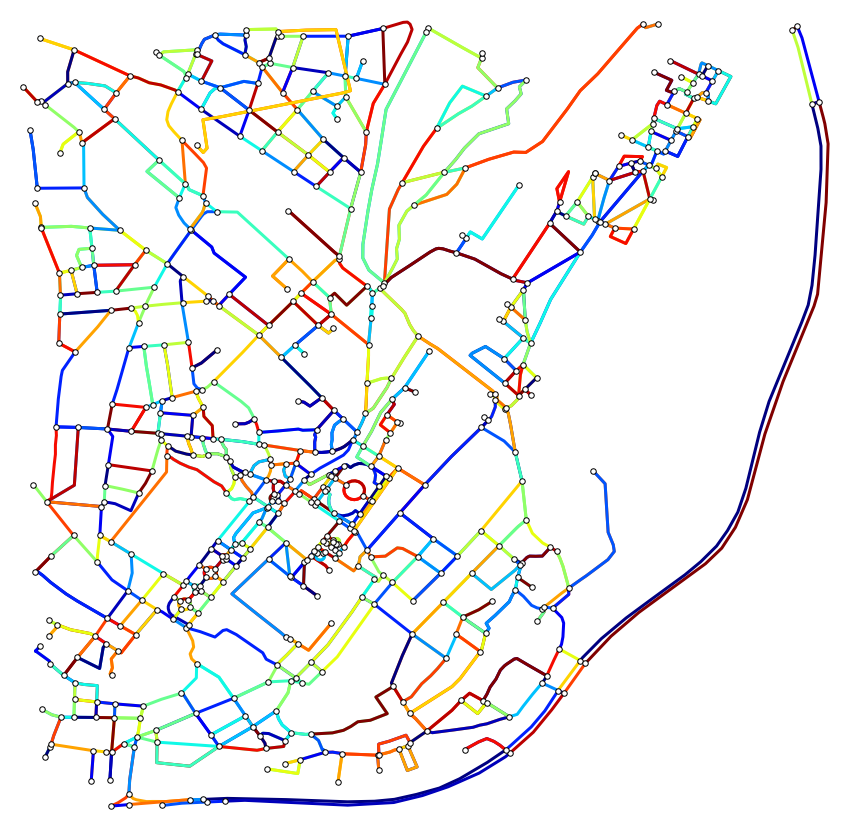

In [104]:
# show the strictly simplified network with edges colored by network length
ec = ox.get_edge_colors_by_attr(G, num_bins=20, cmap= 'jet', attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, node_zorder=3, edge_color=edge_colors, edge_linewidth=3, fig_height=15, fig_width=15)

## Find Shortest Path

Columns in Nodes: ['y', 'x', 'osmid', 'highway', 'lon', 'lat', 'geometry']
Columns in Edges: ['u', 'v', 'key', 'osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry', 'access', 'width', 'tunnel', 'service', 'maxspeed', 'bridge']
Point 1: (665834.7512475121, 4542267.120055672)
Point 2: (666374.3357935023, 4541247.970376974)


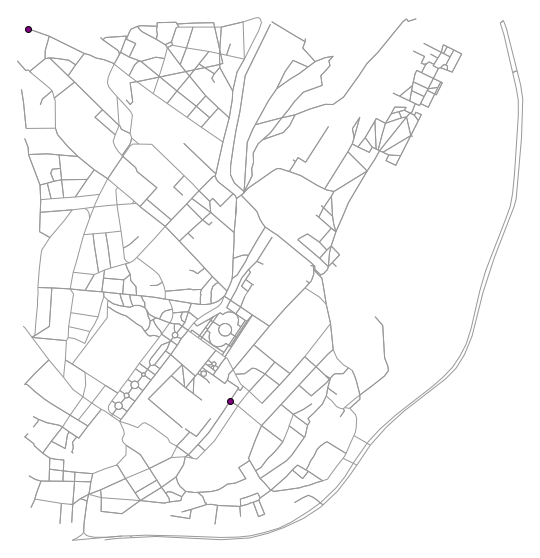

In [122]:
nodes_df, edges_df= ox.graph_to_gdfs(G)
print(f'Columns in Nodes: {list(nodes_df.columns)}\nColumns in Edges: {list(edges_df.columns)}')
# select two random points
indexes = np.random.choice(np.arange(len(nodes_df)),2)
point_1 = (nodes_df.iloc[indexes[0]]['x'],nodes_df.iloc[indexes[0]]['y'])
point_2 = (nodes_df.iloc[indexes[1]]['x'],nodes_df.iloc[indexes[1]]['y'])
print(f'Point 1: {point_1}\nPoint 2: {point_2}')

# visualize the two points
fig, ax = ox.plot_graph(G, fig_height=10, show=False, close=False, node_alpha=0)
ax.scatter(x=nodes_df.iloc[indexes]['x'].values, 
           y=nodes_df.iloc[indexes]['y'].values, zorder=2, color='purple', edgecolors='k')
plt.show()

Distance between Point 1 and Point 2 = 1434 meters


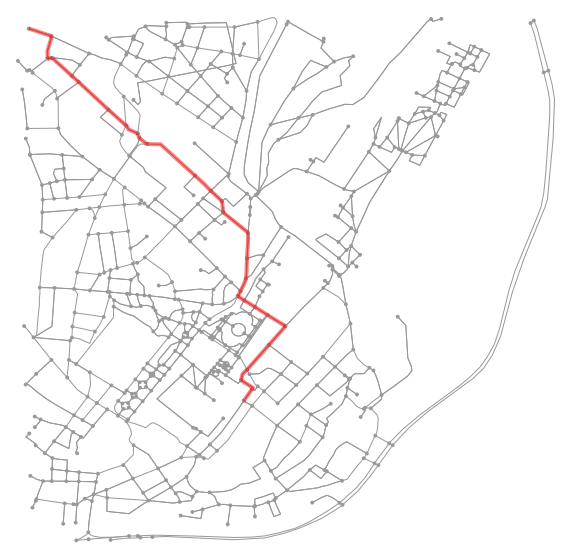

In [132]:
### shortest path distance
#edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
#orig_node = ox.get_nearest_node(G, point_1) ### Unreliable --> needs tweaking
#target_node = ox.get_nearest_node(G, point_2) ### Unreliable --> needs tweaking

length = nx.shortest_path_length(G, source=nodes_df.iloc[indexes[0]].osmid, target=nodes_df.iloc[indexes[1]].osmid, weight='length')
print(f'Distance between Point 1 and Point 2 = {int(length)} meters') 
# Plot the shortest path
fig, ax = ox.plot_graph_route(G, nx.shortest_path(G, source=nodes_df.iloc[indexes[0]].osmid, target=nodes_df.iloc[indexes[1]].osmid, weight='length'), 
                              origin_point=(nodes_df.iloc[indexes[0]].x,nodes_df.iloc[indexes[0]].y), 
                              destination_point=(nodes_df.iloc[indexes[1]].x,nodes_df.iloc[indexes[1]].y), fig_height= 10, fig_width= 10)
plt.show()